In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import numpy as np
import os

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2

from functions import *
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import recall_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device.type}')

Device used: cpu


## **Data augmentation**

To augment the data before training, we will attempt to use two methods:


1.   Scaling
> Scaling is used because we wish to taken into account the varying structure size of tumors and skulls in the images.

2.   Noise Injection
> Noise injection is used to help assist the model in learning the complex patterns around the tumors and make it more robust to small changes in the data.
> We will experiment with both Gaussian (random), and salt-and-paper (random values to min. or max. values, 0 to 255) noise injection.

All combinations of these will be used to determine their effectiveness, and if they introduce any *bias*, *artifacts*, or *overfitting* both in isolation, or combination.

The order of the data augmentation will be:
1.   No Data Augmentation
2.   Scaling
3.   Noise Injection
4.   Scaling, Noise Injection

# Hyperparameters for project

In [2]:
train_size = 0.7
test_size = 1 - train_size
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# Data preprocessing


## Import the dataset
Dataset should be imported as a pytorch dataloader for batch optimization

In [3]:
from customdataset import *
from augmentation import *

train_per = 0.6 # 60% of the data is used for training
val_per = 0.2 # 20% of the data is used for validation
test_per = 0.2 # 20% of the data is used for testing

batch_size = 64

X, Y, num_classes = import_data()

print(f'Number of classes: {num_classes}')
print(f'Number of images: {len(X)}')
print("")

X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y, train_per=train_per, val_per=val_per, test_per=test_per)

print(f'Number of training images: {len(X_train)}')
print(f'Number of validation images: {len(X_val)}')
print(f'Number of testing images: {len(X_test)}')
print("")

dataset_train = MyDataset(X_train, Y_train, augment=True)
dataset_val = MyDataset(X_val, Y_val, augment=False)
dataset_test = MyDataset(X_test, Y_test, augment=False)

print(f'Number of training images: {len(dataset_train)}')
print(f'Number of validation images: {len(dataset_val)}')
print(f'Number of testing images: {len(dataset_test)}')
print("")

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

print(f'Number of training batches: {len(train_loader)}')
print(f'Number of validation batches: {len(val_loader)}')
print(f'Number of testing batches: {len(test_loader)}')
print("")




Number of classes: 4
Number of images: 6400

Number of training images: 3840
Number of validation images: 1280
Number of testing images: 1280

Number of training images: 3840
Number of validation images: 1280
Number of testing images: 1280

Number of training batches: 60
Number of validation batches: 20
Number of testing batches: 20



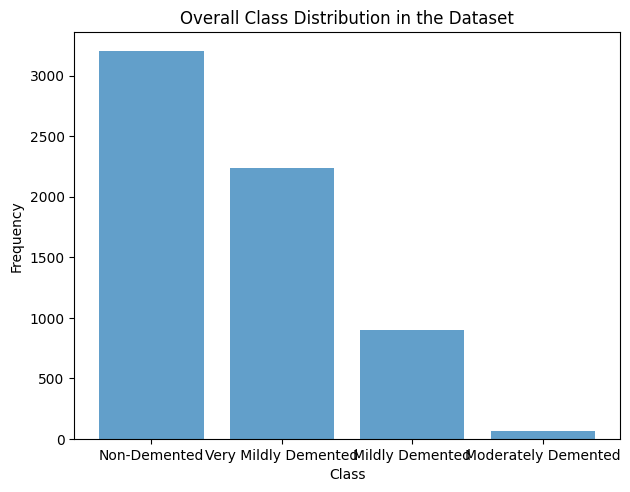

In [32]:
import torch
import matplotlib.pyplot as plt

# Your existing code for dataset and DataLoader initialization

# Class labels mapping
class_labels_mapping = {
    0: 'Non-Demented',
    1: 'Very Mildly Demented',
    2: 'Mildly Demented',
    3: 'Moderately Demented'
}

# Count the occurrences of each class in the combined dataset
class_counts_combined = {class_idx: 0 for class_idx in range(num_classes)}

# Count for the training set
for _, labels in train_loader:
    for label in labels:
        class_counts_combined[label.item()] += 1

# Count for the validation set
for _, labels in val_loader:
    for label in labels:
        class_counts_combined[label.item()] += 1

# Count for the test set
for _, labels in test_loader:
    for label in labels:
        class_counts_combined[label.item()] += 1

# Create a bar plot for the combined dataset
class_labels = list(range(num_classes))
class_frequencies_combined = [class_counts_combined[label] for label in class_labels]

# Increase figure size
plt.figure(figsize=(10, 6))

# Use a horizontal bar plot
plt.barh(class_labels, class_frequencies_combined, alpha=0.7)
plt.ylabel('Class')
plt.xlabel('Frequency')
plt.title('Overall Class Distribution in the Dataset')

# Set y-axis ticks with class labels and rotate them
plt.yticks(class_labels, [class_labels_mapping[label] for label in class_labels], rotation=45)

plt.show()


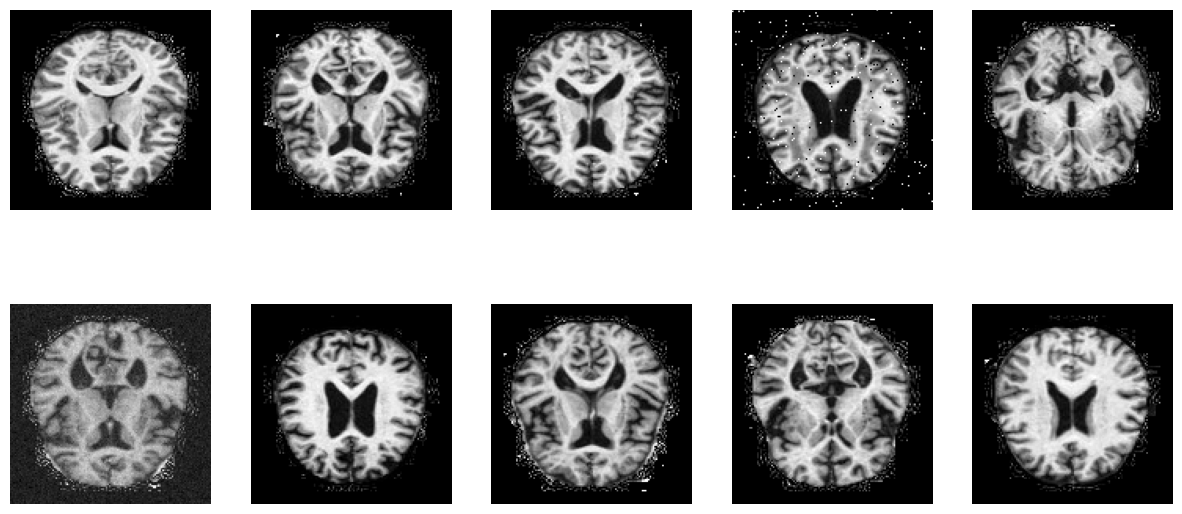

In [4]:
data_loader = train_loader

def dataloader_to_numpy(dataloader):
    images = []
    labels = []
    
    for batch in dataloader:
        batch_images, batch_labels = batch
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    
    return np.concatenate(images), np.concatenate(labels)

# Convert DataLoader to NumPy array
X, Y = dataloader_to_numpy(data_loader)

# Display 10 images
plt.figure(figsize=(15, 7))
num_images_to_display = 10
for i in range(min(num_images_to_display, len(X))):
    image = X[i].squeeze()  # Squeeze to remove the channel dimension for grayscale
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap='gray')  # Specify the colormap for grayscale images
    plt.axis("off")

plt.show()

# Architecture of the network

In [5]:
# training
num_epochs = 40                         # Number of epochs for the training of the nn

# Learning rate und scheduler
initial_learning_rate = 0.01            # Learningrate at start
lr_steps = 10                           # Steps in lr scheduler until lr is updated
lr_gamma = 0.5                          # Faktor the lr is multiplied and updated with

In [6]:
# criterion = FocalLoss()
criterion = nn.CrossEntropyLoss()

# Now define the metrics you want to monitor during training and save them in a dict (Important: All need to take y_pred, y_cls, y_true as input (This order!))
def criterion_function(y_pred, y_cls, y_true):
    return criterion(torch.tensor(y_pred), torch.tensor(y_true))
def accuracy_function(y_pred, y_cls, y_true):
    return accuracy_score(y_true, y_cls)
def recall_function(y_pred, y_cls, y_true):
    return recall_score(y_true, y_cls, average='macro')
metrics = {'loss' : criterion_function, 'acc' : accuracy_function, 'macro recall' : recall_function}

dynamic_model = custom_ConvNet(
    input_channels = 1,
    output_size = 4,
    n_conv_layers1 = 3,
    n_filters1 = 6,
    kernel_size1 = 6,
    n_dense_layers = 3,
    n_dense_initial_nodes = 2**10,
    n_conv_layers2 = 0,
    n_filters2 = 0, 
    kernel_size2 = 0,
    operation_and_factor_filter_size=('*', 2),
    operation_and_factor_dense_network=('/', 4),
    dropout_rate=0.1,
    pooling = [2,2],
    nb_pooling_layers=2,
    activation_function = F.leaky_relu,
    evaluation_metrics=metrics,
    )

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.zeros_(m.bias)
dynamic_model.apply(init_weights)

optimizer = torch.optim.Adam(dynamic_model.parameters(), lr=initial_learning_rate)
lr_scheduler = StepLR(optimizer, step_size=lr_steps, gamma=lr_gamma)
early_stopper = EarlyStopper(dynamic_model, patience=5, min_delta=0)

train_network(dynamic_model, train_loader, criterion, optimizer, num_epochs, lr_scheduler, test_loader, device, early_stopper=early_stopper)

# If you want to save the model
# torch.save(dynamic_model, 'test_model.pth')

Device used for training: cpu
Epoch [1/40]  loss: 1.2198, acc: 0.5617, macro recall: 0.3900
Epoch [2/40]  loss: 1.1602, acc: 0.5922, macro recall: 0.4156
Epoch [3/40]  loss: 1.1312, acc: 0.6484, macro recall: 0.4301
Epoch [4/40]  loss: 1.1110, acc: 0.6430, macro recall: 0.5331
Epoch [5/40]  loss: 1.0583, acc: 0.7172, macro recall: 0.6313
Epoch [6/40]  loss: 1.0418, acc: 0.7312, macro recall: 0.6560
Epoch [7/40]  loss: 1.0060, acc: 0.7617, macro recall: 0.7301
Epoch [8/40]  loss: 0.9749, acc: 0.7930, macro recall: 0.7635
Epoch [9/40]  loss: 0.9555, acc: 0.8133, macro recall: 0.8080
Epoch [10/40]  loss: 0.9438, acc: 0.8258, macro recall: 0.7909
Epoch [11/40]  loss: 0.9009, acc: 0.8734, macro recall: 0.8802
Epoch [12/40]  loss: 0.8835, acc: 0.8852, macro recall: 0.9089
Epoch [13/40]  loss: 0.8709, acc: 0.8977, macro recall: 0.8966
Epoch [14/40]  loss: 0.8673, acc: 0.9016, macro recall: 0.8858
Epoch [15/40]  loss: 0.8522, acc: 0.9086, macro recall: 0.9033
Epoch [16/40]  loss: 0.8462, acc: 

In [7]:
default_parameters = {
    'dropout_rate' : 0.15,
    'pooling' : (2,2),
    'nb_pooling_layers' : 1,
    'evaluation_metrics' : metrics,
    'operation_and_factor_filter_size' : ('*', 2)
}

test_model_2 = custom_ConvNet(1, 4, 2, 12, 5,
                                3, 2**10,
                                2, 6, 4,
                                **default_parameters,
                                )

test_model_2

custom_ConvNet(
  (dnn): ModuleList(
    (0): Linear(in_features=1, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=4, bias=True)
  )
  (cnn1): ModuleList(
    (0): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  )
  (cnn2): ModuleList(
    (0): Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1))
    (1): Conv2d(6, 12, kernel_size=(4, 4), stride=(1, 1))
  )
  (dropout2d): Dropout2d(p=0.15, inplace=False)
  (dropout): Dropout(p=0.15, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

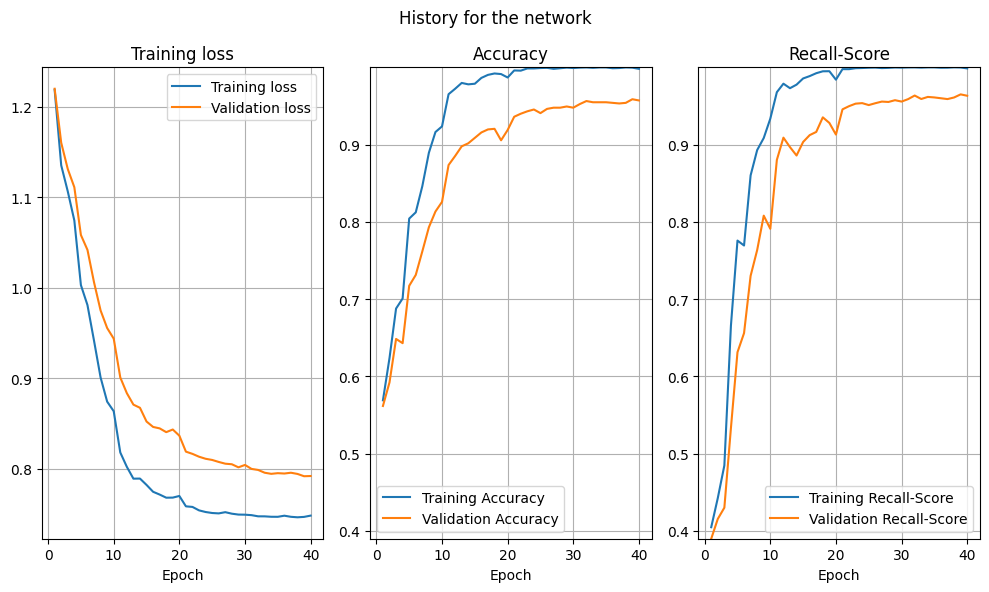

In [8]:
loss_training_hist = dynamic_model.history['loss']
training_acc_hist = dynamic_model.history['acc']
training_w_recall_hist = dynamic_model.history['macro recall']
loss_val_hist = dynamic_model.history_validation['loss']
val_acc_hist = dynamic_model.history_validation['acc']
val_w_recall_hist = dynamic_model.history_validation['macro recall']

x_epochs = np.linspace(1, len(loss_training_hist), len(loss_training_hist))
fig, ax = plt.subplots(1, 3, figsize=(10,6))

# Set the same y-axis limits for ax[1] and ax[2]
max_acc_recall = max(max(training_acc_hist), max(val_acc_hist), max(training_w_recall_hist), max(val_w_recall_hist))
min_acc_recall = min(min(training_acc_hist), min(val_acc_hist), min(training_w_recall_hist), min(val_w_recall_hist))

ax[1].set_ylim([min_acc_recall, max_acc_recall])
ax[2].set_ylim([min_acc_recall, max_acc_recall])

ax[0].plot(x_epochs, loss_training_hist, label = 'Training loss')
ax[0].plot(x_epochs, loss_val_hist, label = 'Validation loss')
ax[0].set(
    xlabel='Epoch',
    title='Training loss'
)

ax[1].plot(x_epochs, training_acc_hist, label='Training Accuracy')
ax[1].plot(x_epochs, val_acc_hist, label='Validation Accuracy')
ax[1].set(
    xlabel='Epoch',
    title = 'Accuracy',
)

ax[2].plot(x_epochs, training_w_recall_hist, label='Training Recall-Score')
ax[2].plot(x_epochs, val_w_recall_hist, label='Validation Recall-Score')
ax[2].set(
    xlabel='Epoch',
    title = 'Recall-Score',
)

fig.suptitle('History for the network')
for i in np.arange(len(ax)):
    ax[i].legend(loc='best')
    ax[i].grid('::')
plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred, y_true = dynamic_model.evaluate(test_loader)
y_cls = np.argmax(y_pred, axis=1)
print(classification_report(y_true, y_cls))
print(confusion_matrix(y_true, y_cls))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       640
           1       0.94      0.96      0.95       448
           2       0.95      0.93      0.94       179
           3       1.00      1.00      1.00        13

    accuracy                           0.96      1280
   macro avg       0.96      0.96      0.96      1280
weighted avg       0.96      0.96      0.96      1280

[[617  18   5   0]
 [ 16 428   4   0]
 [  3   9 167   0]
 [  0   0   0  13]]


## Hyperparameter search

#### Set the hyperparameter space, on which the gridsearch should be done on

The key idea behind this hyperparameter search is to split it into 3 different sequential searches.
The first search looks into the first cnn, which is assigned with the larger kernel.
The second search looks at the second cnn, which has a smaller kernel size.
Finally the parameters for the fully connected layer are searched in the third iteration.

In [10]:
# Define the metrics to monitor during training and save them in a dict
criterion = nn.CrossEntropyLoss()

def criterion_function(y_pred, y_cls, y_true):
    return criterion(torch.tensor(y_pred), torch.tensor(y_true))

def accuracy_function(y_pred, y_cls, y_true):
    return accuracy_score(y_true, y_cls)

def recall_function(y_pred, y_cls, y_true):
    return recall_score(y_true, y_cls, average='macro')

metrics = {'loss' : criterion_function, 'acc' : accuracy_function, 'macro recall' : recall_function}

default_parameters = {
    'dropout_rate' : 0.15,
    'pooling' : (2,2),
    'nb_pooling_layers' : 1,
    'evaluation_metrics' : metrics,
    'operation_and_factor_filter_size' : ('*', 2)
}

In [11]:
from itertools import product
# Phase 1
params_to_test_phase_1= ({
    'n_cnn_layers_1' : [2, 4, 6],
    'n_filters_1' : [6, 12],
    'kernel_size_1' : [5, 8],
})

value_combis = product(*[v for v in params_to_test_phase_1.values()])

hyperparameter_combinations_phase_1 = []
for combi in value_combis:
  hyperparameter_combinations_phase_1.append({key: value for key, value in zip(params_to_test_phase_1.keys(), combi)})

print(f'Total combinations of parameters in phase 1 to be tested: {len(hyperparameter_combinations_phase_1)}')

# Phase 2
params_to_test_phase_2= ({
    'n_cnn_layers_2' : [2, 4],
    'n_filters_2' : [6, 12],
    'kernel_size_2' : [3, 4],
})

value_combis = product(*[v for v in params_to_test_phase_2.values()])

hyperparameter_combinations_phase_2 = []
for combi in value_combis:
  hyperparameter_combinations_phase_2.append({key: value for key, value in zip(params_to_test_phase_2.keys(), combi)})

print(f'Total combinations of parameters in phase 2 to be tested: {len(hyperparameter_combinations_phase_2)}')

# Phase 3
params_to_test_phase_3= ({
    'num_dense_layers' : [3, 5],
    'num_dense_nodes' : [2**10, 2**11, 2**13],
    'factor' : [2, 3],
})

value_combis = product(*[v for v in params_to_test_phase_3.values()])

hyperparameter_combinations_phase_3 = []
for combi in value_combis:
  hyperparameter_combinations_phase_3.append({key: value for key, value in zip(params_to_test_phase_3.keys(), combi)})

print(f'Total combinations of parameters in phase 3 to be tested: {len(hyperparameter_combinations_phase_3)}')

Total combinations of parameters in phase 1 to be tested: 12
Total combinations of parameters in phase 2 to be tested: 8
Total combinations of parameters in phase 3 to be tested: 12


In [13]:
# Function to initialize the weights
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.zeros_(m.bias)

# Hyperparameters, which are not tested
epochs = 3
        
# Define lists to store the histories and the corresponding parameters in
hist_loss_params = {}

# Phase 1   /   Search for best cnn hyperparameters for big kernel

# Dummy variable to store the smallest loss
smallest_loss = np.inf

for i, params in enumerate(hyperparameter_combinations_phase_1):
    print(f'Phase 1: [{len(hyperparameter_combinations_phase_1)} / {i + 1}]')
    # Define model
    test_model = custom_ConvNet(1, 4, params['n_cnn_layers_1'], params['n_filters_1'], params['kernel_size_1'], 3, 2**10, **default_parameters)
    # Setup
    early_stopper = EarlyStopper(test_model, patience=4, min_delta=0)
    optimizer = torch.optim.Adam(test_model.parameters(), lr=0.01)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.5)
    # Training
    train_network(test_model, train_loader, criterion, optimizer, epochs, scheduler, validation_loader, device, early_stopper)

    if np.min(test_model.history_validation['loss']) < smallest_loss:
        best_params_phase_1 = params
        # Save the best weights for the best parameters for the next search to speed up the learning
        state_dict_cnn1 = test_model.cnn1.state_dict()
        state_dict_dnn = test_model.dnn.state_dict()
        smallest_loss = np.min(test_model.history_validation['loss'])


# Phase 2   /   Search for best cnn hyperparameters for small kernel

smallest_loss = np.inf
for i, params in enumerate(hyperparameter_combinations_phase_2):
    print(f'Phase 2: [{len(hyperparameter_combinations_phase_2)} / {i + 1}]')
    # Define model
    test_model_2 = custom_ConvNet(1, 4, best_params_phase_1['n_cnn_layers_1'], best_params_phase_1['n_filters_1'], best_params_phase_1['kernel_size_1'],
                                3, 2**10,
                                params['n_cnn_layers_2'], params['n_filters_2'], params['kernel_size_2'],
                                **default_parameters,
                                )
    # Load the already trained parameters
    test_model_2.cnn1.load_state_dict(state_dict_cnn1)

    # Since first layer of dnn is variable, the fc part needs special treatment
    target_state_dict = test_model_2.dnn.state_dict()
    for name, param in state_dict_dnn.items():
        if "0" not in name:  # Skip the first layer in the source model
            target_state_dict[name].copy_(param)

    test_model_2.dnn.load_state_dict(target_state_dict)

    # Setup
    early_stopper = EarlyStopper(test_model_2, patience=4, min_delta=0)
    optimizer = torch.optim.Adam(test_model_2.parameters(), lr=0.01)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.5)
    # Training
    train_network(test_model_2, train_loader, criterion, optimizer, epochs, scheduler, validation_loader, device, early_stopper)

    if np.min(test_model_2.history_validation['loss']) < smallest_loss:
        best_params_phase_2 = params
        state_dict_cnn1 = test_model_2.cnn1.state_dict()
        state_dict_cnn2 = test_model_2.cnn2.state_dict()
        smallest_loss = np.min(test_model_2.history_validation['loss'])

# Phase 3   /   Search for best fc hyperparameters

smallest_loss = np.inf

for i, params in enumerate(hyperparameter_combinations_phase_3):
    # Define model
    test_model_3 = custom_ConvNet(1, 4, best_params_phase_1['n_cnn_layers_1'], best_params_phase_1['n_filters_1'], best_params_phase_1['kernel_size_1'],
                                params['num_dense_layers'], params['num_dense_nodes'],
                                best_params_phase_2['n_cnn_layers_2'], best_params_phase_2['n_filters_2'], best_params_phase_2['kernel_size_2'],
                                operation_and_factor_dense_network=('//', params['factor']), **default_parameters
                                )
    # Load the already trained parameters
    test_model_3.cnn1.load_state_dict(state_dict_cnn1)
    test_model_3.cnn2.load_state_dict(state_dict_cnn2)
    # Setup
    early_stopper = EarlyStopper(test_model, patience=4, min_delta=0)
    optimizer = torch.optim.Adam(test_model.parameters(), lr=0.01)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.5)
    # Training
    train_network(test_model, train_loader, criterion, optimizer, epochs, scheduler, validation_loader, device, early_stopper)
    # Get history
    loss_training_hist, acc_training_hist, macro_recall_training_hist = test_model.history['loss'], test_model.history['acc'], test_model.history['macro recall']
    loss_validation_hist, acc_validation_hist, macro_recall_validation_hist = test_model.history_validation['loss'], test_model.history_validation['acc'], test_model.history_validation['macro recall']
    # Store the hists etc
    hist_loss_params[tuple(params.items())] = (loss_training_hist, acc_training_hist, macro_recall_training_hist, loss_validation_hist, acc_validation_hist, macro_recall_validation_hist)

    if loss_validation_hist[-1] < smallest_loss:
        torch.save(test_model, 'best_ensample_model.pth')
        best_params_phase_3 = params
        smallest_loss = loss_validation_hist[-1]
    print(f'Phase 3: [{len(hyperparameter_combinations_phase_3)} / {i + 1}]')

# Finally get the dictionary for the best parameters and save it also (for git, so model is reproducible)
best_params_total = dict(best_params_phase_1, **best_params_phase_2, **best_params_phase_3)
with open('best_params.txt', 'w') as txt_file:
    txt_file.write(str(best_params_total))

{'n_cnn_layers_1': 2, 'n_filters_1': 6, 'kernel_size_1': 5}
{'n_cnn_layers_1': 2, 'n_filters_1': 6, 'kernel_size_1': 8}
{'n_cnn_layers_1': 2, 'n_filters_1': 12, 'kernel_size_1': 5}
{'n_cnn_layers_1': 2, 'n_filters_1': 12, 'kernel_size_1': 8}
{'n_cnn_layers_1': 4, 'n_filters_1': 6, 'kernel_size_1': 5}
{'n_cnn_layers_1': 4, 'n_filters_1': 6, 'kernel_size_1': 8}
{'n_cnn_layers_1': 4, 'n_filters_1': 12, 'kernel_size_1': 5}
{'n_cnn_layers_1': 4, 'n_filters_1': 12, 'kernel_size_1': 8}
{'n_cnn_layers_1': 6, 'n_filters_1': 6, 'kernel_size_1': 5}
{'n_cnn_layers_1': 6, 'n_filters_1': 6, 'kernel_size_1': 8}
{'n_cnn_layers_1': 6, 'n_filters_1': 12, 'kernel_size_1': 5}
{'n_cnn_layers_1': 6, 'n_filters_1': 12, 'kernel_size_1': 8}
Phase 1: [12 / 12]
Device used for training: cpu
Epoch [1/30]  loss: 1.1982, acc: 0.5539, macro recall: 0.4250
Epoch [2/30]  loss: 1.1758, acc: 0.5711, macro recall: 0.4328
Epoch [3/30]  loss: 1.1214, acc: 0.6320, macro recall: 0.4837
Epoch [4/30]  loss: 1.1002, acc: 0.6516

In [17]:
for i, params in enumerate(hyperparameter_combinations_phase_3):
    print(params)

{'num_dense_layers': 3, 'num_dense_nodes': 1024, 'factor': 2}
{'num_dense_layers': 3, 'num_dense_nodes': 1024, 'factor': 3}
{'num_dense_layers': 3, 'num_dense_nodes': 2048, 'factor': 2}
{'num_dense_layers': 3, 'num_dense_nodes': 2048, 'factor': 3}
{'num_dense_layers': 3, 'num_dense_nodes': 8192, 'factor': 2}
{'num_dense_layers': 3, 'num_dense_nodes': 8192, 'factor': 3}
{'num_dense_layers': 5, 'num_dense_nodes': 1024, 'factor': 2}
{'num_dense_layers': 5, 'num_dense_nodes': 1024, 'factor': 3}
{'num_dense_layers': 5, 'num_dense_nodes': 2048, 'factor': 2}
{'num_dense_layers': 5, 'num_dense_nodes': 2048, 'factor': 3}
{'num_dense_layers': 5, 'num_dense_nodes': 8192, 'factor': 2}
{'num_dense_layers': 5, 'num_dense_nodes': 8192, 'factor': 3}
